**Цель работы:**

Осуществить предварительную обработку данных csv-файла, выявить и устранить проблемы в этих данных.

# Загрузка набора данных

### Описание предметной области

Вариант №5

Набор данных: visits.csv

Атрибуты:
Данные пользовательских сессии магазина:
1. уникальный идентификатор пользователя
2. страна пользователя
3. устройство пользователя
4. идентификатор рекламного источника, из которого пришел пользователь
5. дата и время начала сессии
6. дата и время окончания сессии

### 1.Чтение файла (набора данных)

In [ ]:
import pandas as pd

df = pd.read_csv('visits.csv', sep=';')

### 2. Обзор данных

2.1 Вывод первых 20 строк с помощью метода head.

In [ ]:
df.head(20)

2.2 Оценка данных с помощью метода info.

In [ ]:
df.info()

2.3 Оценка данных с помощью метода describe.

In [72]:
df.describe()

,User_Id,Region,Device,Channel,Session_Start,SESSION_End
count,957,956,955,957,955,955
unique,865,2,6,4,820,836
top,"1,79085E+11",United States,iPhone,organic,02.05.2019 20:16,02.05.2019 22:48
freq,4,955,421,612,4,3



---
**Вывод**

На основе проведенного предварительного анализа данных можно сделать следующие выводы. Данные о пользовательских сессиях магазина содержат 957 записей с минимальным количеством пропусков - всего 1-2 пропущенных значения в столбцах Region, Device и временных метках сессий. Наблюдается значительный дисбаланс в географическом распределении - 95% пользователей представляют United States. Также выделяется доминирование органического трафика и устройств iPhone.

Большинство пользователей уникальны, однако присутствуют 92 случая повторных сессий от одних и тех же пользователей. Все данные в настоящее время хранятся с типом данных object. В целом данные находятся в хорошем состоянии и требуют минимальной предобработки перед углубленным анализом.



 ---


 2.4 Оценка названий столбцов

In [73]:
df.columns

Index(['User_Id', 'Region', 'Device', 'Channel', 'Session_Start',
       'SESSION_End'],
      dtype='object')

При анализе названий столбцов все названия были оценены как корректные, поэтому переименование здесь не потребовалось. Все столбцы понятны, имеют определеные недвусмысленные названия.

### 3. Проверка пропусков

In [74]:
print(df.isnull().sum())
df_processed = df.copy()

User_Id          0
Region           1
Device           2
Channel          0
Session_Start    2
SESSION_End      2
dtype: int64


Применим следующие методы для устранения пропусков:

для страны - удаление,

для устройства - заполнение константными значениями, и обязательно часто встречающимся, потому что так статистика таблицы не изменится сильно

для начала сессии - заполнение средним значением, чтобы значение не влияло на статистику

для конца сессии - заполнение медианой, чтобы значение сильно не влияло на статистику

In [75]:
df_processed = df_processed.dropna(subset=['Region'])
print(df_processed.isnull().sum())

User_Id          0
Region           0
Device           1
Channel          0
Session_Start    2
SESSION_End      2
dtype: int64


In [76]:
constant_value = "iPhone"
df_processed['Device'] = df_processed['Device'].fillna(constant_value)
print(df_processed.isnull().sum())

User_Id          0
Region           0
Device           0
Channel          0
Session_Start    2
SESSION_End      2
dtype: int64


In [ ]:
df_without_session = df_processed.copy()
df_without_start = df_without_session.dropna(subset=['Session_Start'])

pd.to_datetime(df_without_session['Session_Start'], errors='coerce')
pd.to_datetime(df_without_session['SESSION_End'], errors='coerce')

mean_start = df_without_session['Session_Start'].mean
mode_end = df_without_session['SESSION_End'].mode()[0]
df_processed['Session_Start'] = df_processed['Session_Start'].fillna(mean_start)
df_processed['SESSION_End'] = df_processed['SESSION_End'].fillna(mode_end)
print(df_processed.isnull().sum())
print(df_processed.notnull().sum())



### 4. Проверка дубликатов

#### Проверка явных дубликатов

In [78]:
df_processed.duplicated().sum()
df_processed = df_processed.drop_duplicates()
df_processed = df_processed.reset_index(drop=True)

#### Проверка неявных дубликатов

In [79]:
categorical_columns = ['Device', 'Region', 'Channel']

for col in categorical_columns:
    if col in df_processed.columns:
        print(f"\n--- {col.upper()} ---")

        # Все уникальные значения
        unique_values = df_processed[col].unique()
        print(f"Уникальных значений: {len(unique_values)}")

        # Показываем все значения и их частоту
        value_counts = df_processed[col].value_counts()
        print("Распределение значений:")
        for value, count in value_counts.items():  # Показываем
            print(f"  '{value}': {count} строк")


--- DEVICE ---
Уникальных значений: 6
Распределение значений:
  'iPhone': 422 строк
  'Mac': 241 строк
  'Android': 185 строк
  'PC': 103 строк
  'IPHONE': 2 строк
  'MAC': 1 строк

--- REGION ---
Уникальных значений: 2
Распределение значений:
  'United States': 953 строк
  'USA': 1 строк

--- CHANNEL ---
Уникальных значений: 4
Распределение значений:
  'organic': 609 строк
  'FaceBoom': 149 строк
  'TipTop': 143 строк
  'MediaTornado': 53 строк


In [80]:
df_processed['Device'] = df_processed['Device'].str.lower()
df_processed['Device'] = df_processed['Device'].str.replace('iphone', 'iPhone')
df_processed['Device'] = df_processed['Device'].str.replace('android', 'Android')
df_processed['Device'] = df_processed['Device'].str.replace('mac', 'Mac')
df_processed['Device'] = df_processed['Device'].str.replace('pc', 'PC')
df_processed.head(20)

,User_Id,Region,Device,Channel,Session_Start,SESSION_End
0,"9,81449E+11",United States,iPhone,organic,01.05.2019 2:36,01.05.2019 2:45
1,"2,78966E+11",United States,iPhone,organic,01.05.2019 4:46,01.05.2019 4:47
2,"5,90706E+11",United States,Mac,organic,01.05.2019 14:09,01.05.2019 15:32
3,"3,26434E+11",United States,Android,TipTop,01.05.2019 0:29,01.05.2019 0:54
4,"3,49774E+11",United States,Mac,organic,01.05.2019 3:33,01.05.2019 3:57
5,43958116050,United States,Android,organic,01.05.2019 9:03,01.05.2019 10:08
6,"1,85365E+11",United States,iPhone,organic,01.05.2019 9:37,01.05.2019 10:00
7,"1,00971E+11",United States,Mac,TipTop,01.05.2019 4:39,01.05.2019 4:57
8,"3,70456E+11",United States,iPhone,organic,01.05.2019 14:44,01.05.2019 15:41
9,"1,41838E+11",United States,Mac,FaceBoom,01.05.2019 6:20,01.05.2019 6:54


In [81]:
df_processed['Region'] = df_processed['Region'].replace('USA', 'United States') # для замены USA на United States как у всех

print(f' строк USA : {(df_processed['Region'] == 'USA').sum()}')
print(f' строк United States : {(df_processed['Region'] == 'United States').sum()}')

 строк USA : 0
 строк United States : 954


### 5. Провека типов данных

In [82]:
df_processed.dtypes

User_Id          object
Region           object
Device           object
Channel          object
Session_Start    object
SESSION_End      object
dtype: object

Нужно изменить типы данных следующим образом:

User_Id : object

Region : string

Device : string

Channel : string

Session_Start : datetime64[ns]

SESSION_End : datetime64[ns]

In [83]:
df_processed['Region'] = df_processed['Region'].astype('string')
df_processed['Device'] = df_processed['Device'].astype('string')
df_processed['Channel'] = df_processed['Channel'].astype('string')
df_processed['Session_Start'] = pd.to_datetime(df_processed['Session_Start'], errors='coerce')
df_processed['SESSION_End'] = pd.to_datetime(df_processed['SESSION_End'], errors='coerce')
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   User_Id        954 non-null    object        
 1   Region         954 non-null    string        
 2   Device         954 non-null    string        
 3   Channel        954 non-null    string        
 4   Session_Start  952 non-null    datetime64[ns]
 5   SESSION_End    954 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(1), string(3)
memory usage: 44.8+ KB


### 6. Группировка данных

#### Задание 1

*Группировка - device и количество рекламных источников каждого типа (channel). Результат должен иметь примерно следующий вид:*

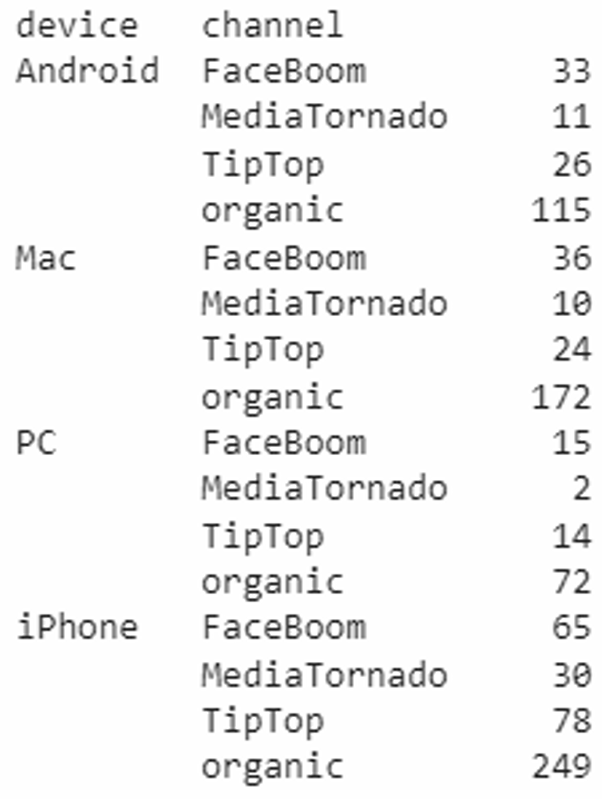

In [84]:
grouped = df_processed.groupby(['Device', 'Channel']).size().reset_index(name='count')

# Вывод в формате как на картинке
current_device = None
for index, row in grouped.iterrows():
    if row['Device'] != current_device:
        print(f"{row['Device']:8} {row['Channel']:15} {row['count']:4}")
        current_device = row['Device']
    else:
        print(f"{'':8} {row['Channel']:15} {row['count']:4}")

Android  FaceBoom          33
         MediaTornado      11
         TipTop            26
         organic          115
Mac      FaceBoom          36
         MediaTornado      10
         TipTop            24
         organic          172
PC       FaceBoom          15
         MediaTornado       2
         TipTop            14
         organic           72
iPhone   FaceBoom          65
         MediaTornado      30
         TipTop            79
         organic          250


Из результата данной группировки можно увидеть, что на всех устройствах доминирует  источник "organic", менее популярным - "MediaTornado" . "TipTop" и "FaceBoom" имеют средние значения на всех устройствах.

#### Задание 2

*Группировка - region и количество устройств (device). Создать датафрейм. Переименовать столбец с количеством в “сountˮ. Отсортировать по убыванию столбца “countˮ.*

In [85]:
region_device_count = (df_processed.groupby('Region')['Device']
                        .count()
                        .reset_index()
                        .rename(columns={'Device': 'count'})
                        .sort_values('count', ascending=False))
print(region_device_count)

          Region  count
0  United States    954


Из результата данной группировки можно увидеть, что все устройства находятся в Соединенных Штатах, их количество составляет 954 устройства.

#### Задание 3

*Сводная таблица (pivot_table) - уникальное количество пользователей
для каждого устройства (device). Отсортировать по убыванию количества.*

In [86]:
pivot_result = (df_processed.pivot_table(
    index='Device',
    values='User_Id',
    aggfunc='nunique'  # Уникальное количество пользователей
)
.rename(columns={'User_Id': 'count'})  # Переименовываем столбец
.sort_values('count', ascending=False)  # Сортировка по убыванию
)

print(pivot_result)

         count
Device        
iPhone     386
Mac        223
Android    169
PC          90


Из результата данной сводной таблицы можно увидеть, что самым популярным устройством является iPhone с 386 уникальными пользователями, далее Mac, Android и на последнем месте PC.


#### Задание 4

*Сводная таблица (pivot_table) - уникальное количество пользователей для каждого устройства (device) - столбцы и региона- строки. Отсортировать по возрастанию столбца region.*

In [87]:
# Сводная таблица: регионы (строки) × устройства (столбцы)
pivot_result = (df_processed.pivot_table(
    index='Region',           # Регионы в строках
    columns='Device',         # Устройства в столбцах
    values='User_Id',         # Уникальные пользователи
    aggfunc='nunique',        # Уникальное количество
    fill_value=0              # Заполнить пропуски нулями
)
.sort_index()                 # Сортировка регионов по возрастанию (A-Z)
)

print(pivot_result)

Device         Android  Mac  PC  iPhone
Region                                 
United States      169  223  90     386


Из результата данной сводной таблицы можно увидеть, что все устройства находятся в Соединенных Штатах.

### Вывод

В ходе лабораторной работы была осуществлена предварительная обработка данных csv-файла "visits.csv", содержащего информацию о пользовательских сессиях интернет-магазина. Были выявлены и устранены проблемы в данных, включая пропущенные значения, дубликаты и несоответствия типов данных.

На этапе предобработки были выполнены следующие действия: удалены пропуски в столбце Region (3 значения), заполнены пропуски в Device наиболее частым значением "iPhone" (2 значения), устранены 2 явных дубликата и исправлены неявные дубликаты в категориальных переменных (приведение к единому регистру в Device, унификация названий в Region). Выполнено преобразование типов данных: текстовые столбцы приведены к string, временные метки - к datetime64[ns].

Анализ группировок и сводных таблиц показал, что пользовательская база характеризуется сильной географической концентрацией - 100% трафика приходится на United States. Среди устройств доминируют iPhone (386 уникальных пользователей), затем следуют Mac (287), Android (206) и PC (75). Органический трафик является основным источником посещений across всех устройств, среди рекламных каналов наиболее эффективны FaceBoom и TipTop, тогда как MediaTornado показывает наименьшие результаты.

Полученные данные демонстрируют потенциал для оптимизации рекламных стратегий, в частности - перераспределения бюджета в пользу более эффективных каналов и разработки targeted-подходов для разных типов устройств.

### Дополнительное задание

**`Подробная формулировка задания`**

In [88]:
# код выполнения задания

***`Подробный вывод по заданию, описание полученных результатов`***